In [9]:
%matplotlib inline

In [59]:
import numpy as np
import pandas as pd
from skimage.morphology import remove_small_holes, remove_small_objects

In [11]:
import matplotlib.pyplot as plt

In [12]:
import config
from utils.io import load_pickle
from utils.torch.datasets import PathologicalImagesDataset, PathologicalImagesDatasetMode
from utils.scoring import topcoder_metric
from predict import get_prediction_filename

In [42]:
nb_folds = 5
model_name='unet_ds'
patch_size_train = 0
patch_size_predict = 0
use_dice = False
use_tta = True

In [43]:
mode = PathologicalImagesDatasetMode.Val
base_dir = config.DATASET_TRAIN_DIR

In [44]:
masks = []
predictions = []
for fold_number in range(nb_folds):
    # load data
    dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)
    
    fold_images = [dataset[i][0] for i in range(len(dataset))]
    fold_masks = [dataset[i][1] for i in range(len(dataset))]    

    fold_masks = np.stack(fold_masks)
    
    # load predictions
    filename = get_prediction_filename(model_name, mode, patch_size_train, patch_size_predict,fold_number, use_dice, use_tta)
    _, fold_predictions = load_pickle(filename) 
    
    masks.append(fold_masks)
    predictions.append(fold_predictions)

In [45]:
masks = np.concatenate(masks, axis=0)
predictions = np.concatenate(predictions, axis=0)

In [46]:
masks.shape, predictions.shape

((168, 500, 500), (168, 500, 500))

In [55]:
threshold = 0.4

In [68]:
predictions_masks = np.zeros_like(predictions, dtype=np.bool)
predictions_masks[predictions>threshold] = 1

In [69]:
score = topcoder_metric(masks, predictions_masks)

In [70]:
print('Score:', score)

Score: 855778.127929


## Remove small objects

In [127]:
scores = []
for size in range(10,200,25):
    predictions_mask_wo = remove_small_objects(predictions_masks.astype(np.bool), size)
    predictions_mask_wh = remove_small_holes(predictions_masks.astype(np.bool), size)
    predictions_mask_who = remove_small_holes(remove_small_objects(predictions_masks.astype(np.bool), size), size)
    
    score_wo = topcoder_metric(masks, predictions_mask_wo.astype(np.float))
    score_wh = topcoder_metric(masks, predictions_mask_wh.astype(np.float))
    score_who = topcoder_metric(masks, predictions_mask_who.astype(np.float))
        
    scores.append({'size': size,'objects': score_wo, 'holes':score_wh, 'objects_holes': score_who})

In [128]:
scores = pd.DataFrame(scores)

In [129]:
scores

,holes,objects,objects_holes,size
0,855779.150770,855783.896329,855784.919054,10
1,855781.935917,855814.254897,855818.063389,35
2,855780.158994,855819.535943,855821.567088,60
3,855787.259297,855800.096919,855809.227562,85
4,855787.259297,855791.553766,855800.684510,110
5,855791.117144,855850.782909,855863.771411,135
6,855791.117144,855798.760820,855811.749324,160
7,855791.117144,855719.480918,855732.469623,185


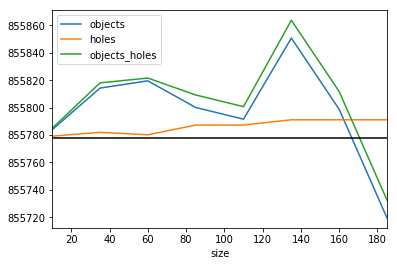

In [130]:
ax = scores.plot(x='size', y=['objects','holes','objects_holes',])
ax.axhline(y=score, c='black')